In [1]:
import json
import datetime
from collections import namedtuple

import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from pyspark.sql import Window, Row

from pysparkling import H2OContext, H2OConf
from h2o.estimators import H2OXGBoostEstimator
import h2o

# H2O function compatible with new and old interface

In [2]:
def create_h2o_context(new=False):
    if new:
        return H2OContext.getOrCreate()
    else:
        spark = get_current_spark_session()
        h2o_conf = (
            H2OConf(spark)
            .use_auto_cluster_start()
            .set_cluster_size(12)
            .set_mapper_xmx("8G")
        )
        return H2OContext.getOrCreate(spark, h2o_conf)

def get_h2o_context():
    h2o_version = h2o.cluster().version
    if h2o_version >= "3.30":
        return H2OContext.getOrCreate()
    else:
        return h2o_context
    
def get_current_spark_session():
    return SparkSession.builder.getOrCreate()

def as_h2o_frame(df):
    h2o_version = h2o.cluster().version
    h2o_context = get_h2o_context() 
    if h2o_version >= "3.30":
        return h2o_context.asH2OFrame(df)
    else:
        return h2o_context.as_h2o_frame(df)

def as_spark_frame(h2o_df):
    h2o_version = h2o.cluster().version
    h2o_context = get_h2o_context() 
    if h2o_version >= "3.30":
        return h2o_context.asSparkFrame(h2o_df) 
    else:
        return h2o_context.as_spark_frame(h2o_df)

In [3]:
h2o_context = create_h2o_context(new=False)

Connecting to H2O server at http://10.147.0.65:54321 ... successful.


H2O cluster uptime:,16 secs
H2O cluster timezone:,Europe/Amsterdam
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.5
H2O cluster version age:,11 months and 3 days !!!
H2O cluster name:,H2O_via_SparklingWater_application_1597844142932_0002
H2O cluster total nodes:,12
H2O cluster free memory:,90.3 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,96
H2O cluster status:,"accepting new members, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.26.5-2.3
 * H2O name: H2O_via_SparklingWater_application_1597844142932_0002
 * cluster size: 12
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,10.147.0.111,54321)
  (1,10.147.0.174,54321)
  (2,10.147.0.174,54323)
  (3,10.147.0.199,54321)
  (4,10.147.0.210,54321)
  (5,10.147.0.213,54321)
  (6,10.147.0.248,54321)
  (7,10.147.0.248,54323)
  (8,10.147.0.249,54321)
  (9,10.147.0.250,54321)
  (10,10.147.0.251,54321)
  (11,10.147.0.252,54321)
  ------------------------

  Open H2O Flow in browser: http://10.147.0.65:54321 (CMD + click in Mac OSX)

    
 * Yarn App ID of Spark application: application_1597844142932_0002
    
 * Yarn App ID of external H2O cluster: application_1597844142932_0003
    


# Get utility functions

In [4]:
def show_sorted_frequencies(df, cols, sort_cols=None, show_n=20, show_truncate=False):
    frequencies_df = get_frequencies_df(df, cols)
    sorted_frequencies_df = sort_frequencies_df(frequencies_df, sort_cols)
    sorted_frequencies_df.show(n=show_n, truncate=show_truncate)


def get_frequencies_df(df, cols):
    abs_freq = sf.count(sf.lit(True)).alias("abs_freq")
    total = sf.sum("abs_freq").over(Window.partitionBy())
    rel_freq = sf.col("abs_freq")/total
    return (
        df
        .groupby(cols)
        .agg(abs_freq)
        .withColumn("rel_freq", rel_freq)
    )


def sort_frequencies_df(frequencies_df, sort_cols=None):
    if sort_cols is None:
        sort_cols = sf.desc("abs_freq")
    return frequencies_df.sort(sort_cols)


ssf = show_sorted_frequencies

# Get data (control group)

In [5]:
def get_data_df(metadata, start_date, end_date):
    data_df = (
        spark
        .table(metadata["training_table_name"])
        .filter(sf.col("yyyy_mm_dd").between(start_date, end_date))
    ) 

    label_timestamp_df = (
        spark
        .table("paymentfraud.unified_labels")
        .select("request_id", "paymentfraud_timestamp")
    )
    data_with_label_timestamp_df = data_df.join(label_timestamp_df, on="request_id", how="inner")

    assert data_df.count() == data_with_label_timestamp_df.count()
    return data_with_label_timestamp_df

# Model functions

In [6]:
def get_train_val_test_h2o_dfs(data_df, metadata):
    return [get_data_set_h2o_df(data_df, metadata, data_set) 
            for data_set in ["train", "val", "test"]]


def get_data_set_h2o_df(data_df, metadata, data_set):
    data_set_df = filter_data_set_dates(data_df, metadata, data_set)
    return spark_to_h2o_frame(data_set_df, metadata)


def filter_data_set_dates(data_df, metadata, data_set):
    start_date = metadata["dates"]["{}_start_date".format(data_set)]
    end_date = metadata["dates"]["{}_end_date".format(data_set)]
    return (
        data_df
        .filter(sf.col("yyyy_mm_dd").between(start_date, end_date))
    )  

def spark_to_h2o_frame(df, metadata):
    h2o_df = as_h2o_frame(df)
    for factor_col in [metadata["target_col"]] + metadata["categorical_features"]:
        h2o_df[factor_col] = h2o_df[factor_col].asfactor()
    return h2o_df


def train_h2o_model(train_h2o_df, metadata, val_h2o_df=None, h2o_model_seed=10):
    model = H2OXGBoostEstimator(seed=h2o_model_seed, **metadata["model_params"])
    
    features = metadata["numerical_features"] + metadata["categorical_features"]
    target_col = metadata["target_col"]
    model.train(
        x=features,
        y=target_col,
        training_frame=train_h2o_df,
        validation_frame=val_h2o_df
    )
    return model

In [7]:
def predict_and_get_h2o_df(h2o_df, model):
    pred_h2o_df = model.predict(h2o_df)
    pred_h2o_df["model_score"] = pred_h2o_df["p1"]
    
    relevant_columns = ["request_id", "yyyy_mm_dd", "timestamp", "control_group", "binary_label"]
    return h2o_df[relevant_columns].cbind(pred_h2o_df[["model_score"]])


def predict_and_get_spark_df(h2o_df, model):
    prediction_h2o_df = predict_and_get_h2o_df(h2o_df, model)
    return as_spark_frame(prediction_h2o_df)


def predict_and_get_pandas_df(h2o_df, model):
    from pytz.exceptions import UnknownTimeZoneError
    
    prediction_spark_df = predict_and_get_spark_df(h2o_df, model)
    label_casted_as_int_df = (
        prediction_spark_df
        .withColumn("binary_label", sf.col("binary_label").cast("int"))
    )
    # At the moment .toPandas() throws `UnknownTimeZoneError: ':/etc/localtime'`
    # on spark kubernetes if the spark dataframe contains a timestamp
    try:
        return label_casted_as_int_df.toPandas()
    except UnknownTimeZoneError:
        return (
            label_casted_as_int_df
            .withColumn("yyyy_mm_dd", sf.col("yyyy_mm_dd").cast("string"))
            .toPandas()
        )

# Modifying metadata functions

In [8]:
def set_default_dates(metadata):
    metadata["dates"]["train_start_date"] = "2019-02-15"
    metadata["dates"]["train_end_date"] = "2019-08-14"
    metadata["dates"]["val_start_date"] = "2019-08-15"
    metadata["dates"]["val_end_date"] = "2019-08-30"
    metadata["dates"]["test_start_date"] = "2019-11-01"
    metadata["dates"]["test_end_date"] = "2019-11-08"
    return metadata


def set_default_model_params(metadata):
    metadata["model_params"] = {
        "ntrees": 75,
        "col_sample_rate": 0.3,
        "learn_rate": 0.2,
        "col_sample_rate_per_tree": 0.3,
        "max_depth": 8,
        "min_rows": 32,
        "min_split_improvement": 1e-05,
        "sample_rate": 0.9,
        "reg_lambda": 0.2,
        "reg_alpha": 0.1
    }
    return metadata


def move_categorical_features_to_numerical(metadata):
    # I found better results when treating all features as numerical
    metadata["numerical_features"] += metadata["categorical_features"]
    metadata["categorical_features"] = []
    return metadata


def get_biased_train_metadata(metadata):
    return {
        "dates": {
            "biased_train_start_date": metadata["dates"]["train_start_date"],
            "biased_train_end_date": add_days(metadata["dates"]["test_start_date"], -1),
        }
    }    


def add_days(date_string, days):
    source_date = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    new_date = source_date + datetime.timedelta(days)
    return datetime.datetime.strftime(new_date, '%Y-%m-%d')


def test_move_categorical_features_to_numerical():
    metadata = {
        "numerical_features": ["f1", "f2", "f3"],
        "categorical_features": ["c1", "c2"]
    }
    expected_metadata = {
        "numerical_features": ["f1", "f2", "f3", "c1", "c2"],
        "categorical_features": []
    }
    metadata = move_categorical_features_to_numerical(metadata)
    assert metadata == expected_metadata
    
    metadata_second_time = move_categorical_features_to_numerical(metadata)
    assert metadata_second_time == expected_metadata
   

def test_add_days():
    assert add_days("2019-05-01", 1) == "2019-05-02"
    assert add_days("2019-05-01", 0) == "2019-05-01"
    assert add_days("2019-05-01", -1) == "2019-04-30"
    assert add_days("2019-12-31", 1) == "2020-01-01"

    
def test_get_biased_train_metadata():
    metadata = {"dates": {}}
    metadata["dates"]["train_start_date"] = "2019-02-15"
    metadata["dates"]["train_end_date"] = "2019-08-14"
    metadata["dates"]["val_start_date"] = "2019-08-15"
    metadata["dates"]["val_end_date"] = "2019-08-30"
    metadata["dates"]["test_start_date"] = "2019-11-01"
    metadata["dates"]["test_end_date"] = "2019-11-08"   
    biased_train_metadata = get_biased_train_metadata(metadata)
    expected = {
        "dates": {
            "biased_train_start_date": "2019-02-15",
            "biased_train_end_date": "2019-10-31",
        }
    }
    assert biased_train_metadata == expected
    

test_move_categorical_features_to_numerical()
test_add_days()
test_get_biased_train_metadata()
print("ran all tests")

ran all tests


# Biased training df

In [9]:
def get_biased_train_h2o_df(data_df, metadata):
    biased_train_metadata = get_biased_train_metadata(metadata)
    train_df = filter_data_set_dates(data_df, biased_train_metadata, "biased_train")

    labels_known_before_date = metadata["dates"]["test_start_date"]
    biased_df = get_biased_df(train_df, labels_known_before_date)
    return spark_to_h2o_frame(biased_df, metadata)


def get_biased_df(data_df, labels_known_before_date):
    y_0_df = data_df.withColumn("binary_label", sf.lit(0))
    y_1_df = data_df.filter(sf.to_date("paymentfraud_timestamp")<labels_known_before_date)
    return y_0_df.union(y_1_df)


def test_get_biased_df():
    data_df = spark.createDataFrame([
        Row(binary_label=0, paymentfraud_timestamp=None),
        Row(binary_label=0, paymentfraud_timestamp=None),
        Row(binary_label=0, paymentfraud_timestamp=None),
        Row(binary_label=1, paymentfraud_timestamp="2019-05-01 12:00:00"),
        Row(binary_label=1, paymentfraud_timestamp="2019-08-01 12:00:00"),
    ])
    expected_df = spark.createDataFrame([
        Row(binary_label=0, paymentfraud_timestamp=None),
        Row(binary_label=0, paymentfraud_timestamp=None),
        Row(binary_label=0, paymentfraud_timestamp=None),
        Row(binary_label=0, paymentfraud_timestamp="2019-05-01 12:00:00"),
        Row(binary_label=0, paymentfraud_timestamp="2019-08-01 12:00:00"),
        Row(binary_label=1, paymentfraud_timestamp="2019-05-01 12:00:00"),
    ])
    biased_df = get_biased_df(data_df, "2019-06-01")
    assert dataframes_are_equal(biased_df, expected_df)
    

def dataframes_are_equal(df1, df2):
    if df1.columns == df2.columns:
        sort_col = sf.struct(df1.columns)
        df1_values = [tuple(row) for row in df1.sort(sort_col).collect()]
        df2_values = [tuple(row) for row in df2.sort(sort_col).collect()]
        return df1_values == df2_values
    else:
        return False
    

test_get_biased_df()
print("Passed tests")

Passed tests


# Main script

In [10]:
metadata = json.load(open("incremental_learning_boreas_config.json"))
metadata = set_default_dates(metadata)
metadata = set_default_model_params(metadata)
metadata = move_categorical_features_to_numerical(metadata)

In [19]:
data_df = get_data_df(metadata, "2019-01-01", "2020-05-01").repartition(20).cache()

In [12]:
train_h2o_df, val_h2o_df, test_h2o_df =  get_train_val_test_h2o_dfs(data_df, metadata)

In [13]:
model = train_h2o_model(train_h2o_df, metadata)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


# Now let's loop over test dates

In [14]:
def get_biased_model_for_test_date(data_df, test_start_date):
    metadata = get_metadata_for_test_date(test_start_date)
    biased_train_h2o_df = get_biased_train_h2o_df(data_df, metadata)
    return train_h2o_model(biased_train_h2o_df, metadata)
    

def get_test_h2o_df_for_test_date(data_df, test_start_date):
    metadata = get_metadata_for_test_date(test_start_date)
    return get_data_set_h2o_df(data_df, metadata, "test")


def get_metadata_for_test_date(test_start_date):
    metadata = initialise_metadata()
    return set_test_period(metadata, test_start_date)

    
def initialise_metadata():
    metadata = json.load(open("incremental_learning_boreas_config.json"))
    metadata = set_default_dates(metadata)
    metadata = set_default_model_params(metadata)
    metadata = move_categorical_features_to_numerical(metadata)    
    return metadata

def set_test_period(metadata, test_start_date):
    metadata['dates']['test_start_date'] = test_start_date
    metadata['dates']['test_end_date'] = add_days(test_start_date, 6)
    return metadata

In [20]:
test_start_dates = [
    '2019-11-14',
    '2019-11-21',
    '2019-11-28',
    '2019-12-05',
    '2019-12-12',
    '2019-12-19',
    '2019-12-26',
    '2020-01-02',
    '2020-01-09',
    '2020-01-16',
    '2020-01-23',
    '2020-01-30',
    '2020-02-06',
    '2020-02-13',
    '2020-02-20',
    '2020-02-27',
    '2020-03-05'
]
biased_models = {
    test_start_date: get_biased_model_for_test_date(data_df, test_start_date) 
    for test_start_date in test_start_dates
}
test_h2o_dfs = {
    test_start_date: get_test_h2o_df_for_test_date(data_df, test_start_date) 
    for test_start_date in test_start_dates
}

xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |████████████████████████████████████████████| 100%
xgboost Model Build progres

# Now let's add confidence intervals

In [21]:
def get_prauc_estimate_and_conf_interval_from_h2o_df(h2o_df, model, n_samples=1000, conf_level=0.9):
    pred = predict_and_get_pandas_df(h2o_df, model)
    prauc = get_prauc(pred)
    bootstrapped_praucs = get_bootstrapped_praucs(pred, n_samples=n_samples)
    prauc_lower_bound, prauc_upper_bound = get_confidence_interval(bootstrapped_praucs, conf_level)
    return prauc, prauc_lower_bound, prauc_upper_bound


def get_bootstrapped_praucs_from_h2o_df(h2o_df, model, n_samples=10):
    pred = predict_and_get_pandas_df(h2o_df, model)
    return get_bootstrapped_praucs(pred, n_samples)


def get_bootstrapped_praucs(pred, n_samples=10):
    return [get_prauc(pred.sample(frac=1, replace=True)) for _ in range(n_samples)]


def get_prauc(pred: pd.DataFrame):
    return average_precision_score(pred["binary_label"], pred["model_score"])


def get_confidence_interval(bootstrapped_sample, conf_level):
    x = (1-conf_level)/2*100
    return np.percentile(bootstrapped_sample, [x, 100-x])


def get_delta_prauc_estimate_and_conf_interval(h2o_df, model1, model2, 
                                               n_samples=1000, conf_level=0.9):
    two_model_preds = get_two_model_predictions(h2o_df, model1, model2)
    delta_prauc = get_delta_prauc(two_model_preds)
    bootstrapped_delta_praucs = get_bootstrapped_delta_praucs(two_model_preds, n_samples=n_samples)
    delta_prauc_lower_bound, delta_prauc_upper_bound = get_confidence_interval(
        bootstrapped_delta_praucs,
        conf_level
    )
    return delta_prauc, delta_prauc_lower_bound, delta_prauc_upper_bound    


def get_two_model_predictions(h2o_df, model1, model2):
    pred1_df = predict_and_get_spark_df(h2o_df, model1)
    pred2_df = predict_and_get_spark_df(h2o_df, model2)
    two_model_pred_df = (
        pred1_df
        .join(pred2_df, on="request_id", how="inner")
        .select(
            pred1_df.request_id,
            pred1_df.binary_label.cast("int"),
            pred1_df.model_score.alias("model1_score"),
            pred2_df.model_score.alias("model2_score"),
        )
    )
    return two_model_pred_df.toPandas()


def get_bootstrapped_delta_praucs(pred, n_samples=10):
    return [get_delta_prauc(pred.sample(frac=1, replace=True)) for _ in range(n_samples)]


def get_delta_prauc(two_model_preds: pd.DataFrame):
    prauc1 = average_precision_score(two_model_preds["binary_label"], two_model_preds["model1_score"])
    prauc2 = average_precision_score(two_model_preds["binary_label"], two_model_preds["model2_score"])
    return prauc1 - prauc2

In [22]:
method_metric_names = [f"{method}_{metric}" for method in ["static", "biased", "delta"] 
                       for metric in ["prauc", "prauc_ub", "prauc_lb"]]
ResultRow = namedtuple("ResultRow", ["test_start_date"]+method_metric_names)

In [23]:
results = []
for test_start_date in test_start_dates:
    biased_model = biased_models[test_start_date]
    test_h2o_df = test_h2o_dfs[test_start_date]
    static_metrics = get_prauc_estimate_and_conf_interval_from_h2o_df(test_h2o_df, model)
    biased_metrics = get_prauc_estimate_and_conf_interval_from_h2o_df(test_h2o_df, biased_model)
    delta_metrics = get_delta_prauc_estimate_and_conf_interval(test_h2o_df, biased_model, model)
    metrics = list(static_metrics) + list(biased_metrics) + list(delta_metrics)
    result = ResultRow(test_start_date, *metrics)
    results.append(result)
    print(result)

xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
ResultRow(test_start_date='2019-11-14', static_prauc=0.5748614578068305, static_prauc_ub=0.48943423496010474, static_prauc_lb=0.6654501354364768, biased_prauc=0.5813049514035045, biased_prauc_ub=0.4929159933980721, biased_prauc_lb=0.6785967948993431, delta_prauc=0.006443493596673955, delta_prauc_ub=-0.05255190662938902, delta_prauc_lb=0.07178358955287634)
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████|

In [24]:
results

[ResultRow(test_start_date='2019-11-14', static_prauc=0.5748614578068305, static_prauc_ub=0.48943423496010474, static_prauc_lb=0.6654501354364768, biased_prauc=0.5813049514035045, biased_prauc_ub=0.4929159933980721, biased_prauc_lb=0.6785967948993431, delta_prauc=0.006443493596673955, delta_prauc_ub=-0.05255190662938902, delta_prauc_lb=0.07178358955287634),
 ResultRow(test_start_date='2019-11-21', static_prauc=0.47135754833207844, static_prauc_ub=0.3880692121114947, static_prauc_lb=0.5716769687781579, biased_prauc=0.5088927428955227, biased_prauc_ub=0.41672822733593673, biased_prauc_lb=0.6131264495331954, delta_prauc=0.03753519456344423, delta_prauc_ub=-0.012298693008423685, delta_prauc_lb=0.09872014622627512),
 ResultRow(test_start_date='2019-11-28', static_prauc=0.6508653353347751, static_prauc_ub=0.5802320532667513, static_prauc_lb=0.7246029690650828, biased_prauc=0.6248888276774666, biased_prauc_ub=0.5451388231575548, biased_prauc_lb=0.7002414149276011, delta_prauc=-0.0259765076573

In [25]:
def to_pandas_results(result_row_list):
    pandas_df = pd.DataFrame(result_row_list)
    return set_date_as_index(pandas_df, "test_start_date")


def set_date_as_index(pandas_df, date_column):
    dates = pd.to_datetime(pandas_df[date_column])
    return pandas_df.set_index(dates)

In [26]:
r = to_pandas_results(results)

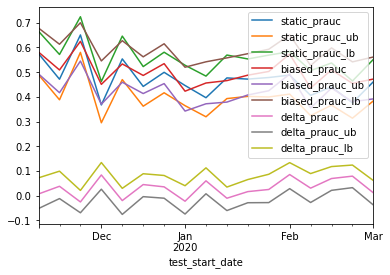

In [27]:
r.plot()

In [28]:
def plot_series_with_confint(pdf, method, color, label):
    lb = f"{method}_prauc_lb"
    ub = f"{method}_prauc_ub"
    point = f"{method}_prauc"
    plt.plot(pdf.index, pdf[lb], color=color, alpha=0.1)
    plt.plot(pdf.index, pdf[ub], color=color, alpha=0.1)
    plt.plot(pdf.index, pdf[point], color=color, label=label)

    plt.fill_between(
                x=pdf.index,
                y1=pdf[ub],
                y2=pdf[lb],
                alpha=0.2,
                color=color
            )

In [29]:
TITLE = "Comparing model 'trained once' vs model trained using 'fake negative sampling'"

In [30]:
def plot_delta():
    plt.figure(figsize=[12,6])
    plot_series_with_confint(r, "delta", "green", "Delta PR-AUC")
    plt.legend()
    plt.xticks(rotation=90)
    plt.title(TITLE, fontsize = 16)
    plt.xlabel('Week of test set')
    plt.ylabel('PR-AUC')
    plt.axhline(0, color="k", linestyle="dashed")

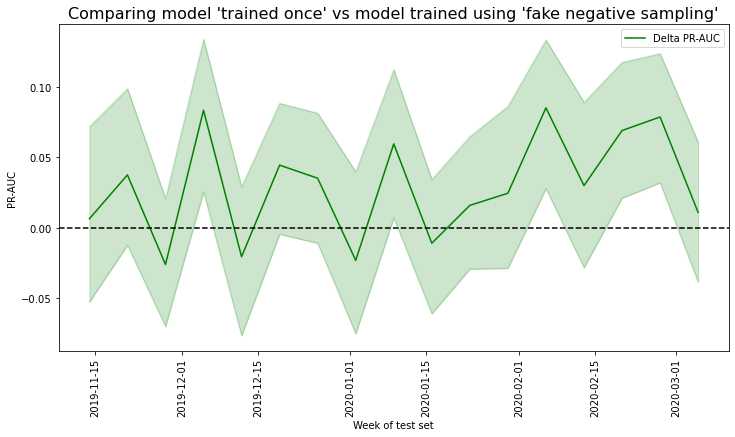

In [31]:
plot_delta()

In [32]:
def make_final_plot(pdf, confint=True):
    plt.figure(figsize=[12,6])
    
    if confint:
        plot_series_with_confint(pdf, "static", "dodgerblue", "no retraining")
        plot_series_with_confint(pdf, "biased", "orange", "fake negative calibraition")
    else:
        plt.plot(pdf.index, pdf.static_prauc, color="dodgerblue", label="no retraining", linewidth=3)
        plt.plot(pdf.index, pdf.biased_prauc, color="orange", label="fake negative calibraition", linewidth=3)
    
    
    plt.legend()
    plt.xticks(rotation=90)
    plt.title(TITLE, fontsize = 16)
    plt.xlabel("Week of test set")
    plt.ylabel("PR-AUC")

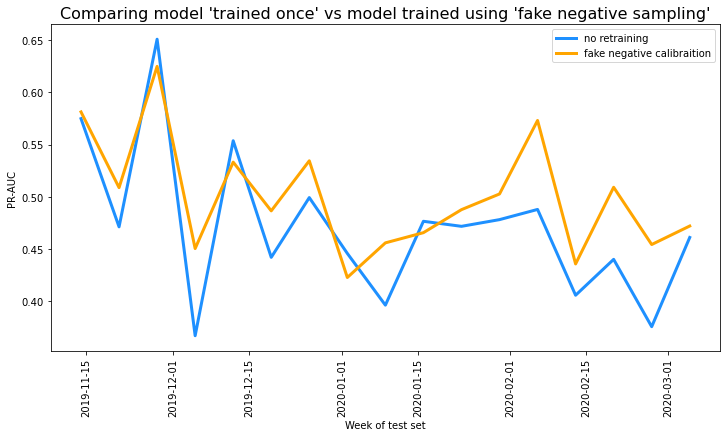

In [33]:
make_final_plot(r, confint=False)